In [463]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from itertools import cycle
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import warnings
from scipy.stats import kruskal
warnings.filterwarnings('ignore', category=FutureWarning)
np.random.seed(42)

In [464]:
start_data, end_data = datetime(2022,6,1),datetime(2022,8,1)
df = pd.DataFrame({'date': [start_data + timedelta(days=i) for i in range((end_data - start_data).days + 1)]})
# to generate around these values +- 10 % 
value_intervals = {0: 650, 1: 720, 2: 1600, 3: 1500, 4: 2200, 5: 2200, 6: 1400}
# income of company to start from it to  generate random num of tables and income for every waiter, will be deleted
df['fake_income'] = df['date'].dt.weekday.map(lambda x: np.random.uniform(value_intervals[x] * 0.9,value_intervals[x] * 1.1)).map(\
    lambda x: round(x,2))
df['day_of_week'] = df['date'].dt.weekday
waiters_shifts = [cycle([1, 1, 0, 0]), cycle([0, 1, 1, 0]), cycle([0, 0, 1, 1]), cycle([1, 0, 0, 1])]

# creating work shifts as 1 working day 0 not
for i in range(4):
    df['work_shif_w_{}'.format(i)] = [next(waiters_shifts[i]) for _ in range(len(df))]
    
# in the shift 2 waiters, fake income/2 if waiter works
for i in range(4):
    df['work_shif_w_{}'.format(i)] = df.apply(lambda row: row['fake_income'] / 2 if row['work_shif_w_{}'.format(i)] != 0 else 0, axis=1)
    
# to give them a bit of random chaos in income +- 10 %
for i in range(4):
    df['work_shif_w_{}'.format(i)] = df['work_shif_w_{}'.format(i)].apply(lambda x: round(np.random.uniform(x*0.9, x*1.1),2))

df.drop(['fake_income','day_of_week' ], axis = 1, inplace = True)

# to generate tables for every waiter with average bill is 26 EUR
for i in range(4):
    df['tables_waiter_{}'.format(i)] = df['work_shif_w_{}'.format(i)].apply(lambda x: round(x/26))

# to generate new average bill
for i in range(4):
    df['average_bill_w_{}'.format(i)] = df.apply(lambda row, i=i: row['work_shif_w_{}'.format(i)] /\
        row['tables_waiter_{}'.format(i)] if row['work_shif_w_{}'.format(i)] != 0 else 0, axis=1).map(lambda x: round(x,2))

# 3rd waiter has bigger average bill 0-10%
df['average_bill_w_2'] = df['average_bill_w_2'].apply(lambda x: round(np.random.uniform(x, x*1.1),2))
df['work_shif_w_2'] = df['average_bill_w_2'] * df['tables_waiter_2']

# 4th waiter has bigger average bill 5-15%
df['average_bill_w_3'] = df['average_bill_w_3'].apply(lambda x: round(np.random.uniform(x*1.05, x*1.15),2))
df['work_shif_w_3'] = df['average_bill_w_3'] * df['tables_waiter_3']

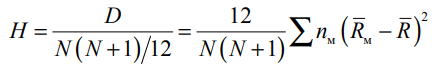, criteria kruskall wallis equal to $χ^2$, if groups not too small else use their tables

In [465]:
calculation_list = ['work_shif_w_', 'tables_waiter_', 'average_bill_w_']
interpirtation = {'work_shif_w_':'income','tables_waiter_':'table','average_bill_w_':'average_bill'}
days_of_week_dict = {0: 'Monday',1: 'Tuesday',2: 'Wednesday',
                    3: 'Thursday',4: 'Friday',5: 'Saturday', 6: 'Sunday'}

# I will have 7 experiments: Monday - Sunday and 4 waiters (groups) and 3 calculations = 28 experements
for i in range(7): # 7 days
    for j in range(3): # 3 calculation(income, average, tables)
        list_of_values_per_waiter = [] # list [day,calculation type, waiter, his list by filter]
        for z in range(4): # by waiters
            # to get list from folter day calculation and waiter
            x = df[(df[calculation_list[j] + str(z)] != 0) & (df['date'].dt.weekday == i)][calculation_list[j] + str(z)].tolist()
            list_of_values_per_waiter.append(x)    
        # to see if there is statistic difference   
        statistic, p_value = kruskal(*list_of_values_per_waiter)
        if p_value <=0.05:
            print('For',days_of_week_dict[i], ", Calculation via", interpirtation[calculation_list[j]],", Statistic:", round(statistic,2),", p-value:", round(p_value,2))
            
            #ok I find statistic and to find exactly where
            for tt in range(len(list_of_values_per_waiter)):
                for gg in range(tt + 1, len(list_of_values_per_waiter)):
                    group1 = list_of_values_per_waiter[tt]
                    group2 = list_of_values_per_waiter[gg]
                    
                    # I did not find Newman—Kales criteria for non parametric values      
                    stat, p = mannwhitneyu(group1, group2)
                    if p <= 0.05:
                        print("--Comparison between waiter --", tt+1, "and waiter --", gg+1, '- p value is ',round(p,2))
    print('------------'*10)         

For Monday , Calculation via average_bill , Statistic: 10.22 , p-value: 0.02
--Comparison between waiter -- 1 and waiter -- 4 - p value is  0.02
--Comparison between waiter -- 2 and waiter -- 4 - p value is  0.02
------------------------------------------------------------------------------------------------------------------------
For Tuesday , Calculation via income , Statistic: 9.4 , p-value: 0.02
--Comparison between waiter -- 1 and waiter -- 3 - p value is  0.03
--Comparison between waiter -- 1 and waiter -- 4 - p value is  0.03
--Comparison between waiter -- 2 and waiter -- 4 - p value is  0.03
For Tuesday , Calculation via average_bill , Statistic: 9.75 , p-value: 0.02
--Comparison between waiter -- 1 and waiter -- 4 - p value is  0.03
--Comparison between waiter -- 2 and waiter -- 4 - p value is  0.03
------------------------------------------------------------------------------------------------------------------------
For Wednesday , Calculation via income , Statistic: 12.48 

In [466]:
# creating the desired result s average + 9 %
df['average_best'] = (df['average_bill_w_0'] + df['average_bill_w_1'] +\
    df['average_bill_w_2'] + df['average_bill_w_3']).apply(lambda x: round(((x/2)*1.09 ),2))
df['tables_best'] = (df['tables_waiter_0'] + df['tables_waiter_1'] + \
    df['tables_waiter_2'] + df['tables_waiter_3']).apply(lambda x: round(((x/2)*1.09),2))
df['income_best'] = (df['work_shif_w_0'] + df['work_shif_w_1'] +\
    df['work_shif_w_2'] + df['work_shif_w_3']).apply(lambda x: round(((x/2)*1.09),2))

# for visualisation via means values for every days of week and waiters + desired result
list_avareges, list_income, list_tables = [], [], []

for i in range(7):# via days
    via_days_average, via_days_income, via_days_tables = [], [], [] # temporary lists of results via days
    for j in range(4):
        # adding mean values via waiters
        via_days_average.append(df[df['date'].dt.weekday == i]['average_bill_w_{}'.format(j)].mean().round(2) * 2)
        via_days_income.append(df[df['date'].dt.weekday == i]['work_shif_w_{}'.format(j)].mean().round(2) * 2)
        via_days_tables.append(df[df['date'].dt.weekday == i]['tables_waiter_{}'.format(j)].mean().round(2) * 2)
    # adding 5th postion 'best' waiter (we'd like) 
    via_days_average.append(df[df['date'].dt.weekday == i]['average_best'].mean().round(2))
    via_days_income.append(df[df['date'].dt.weekday == i]['income_best'].mean().round(2))
    via_days_tables.append(df[df['date'].dt.weekday == i]['tables_best'].mean().round(2))
    # adding to main list with format 0-1-2-3 waiters(lists) + best waiter lists
    list_avareges.append(via_days_average)
    list_income.append(via_days_income)
    list_tables.append(via_days_tables)

# strings == days, rows == mean values of waiters  --> string == mean values of waiters , row = days
list_avareges, list_income, list_tables = list(map(list, zip(*list_avareges))), list(map(list, zip(*list_income))), list(map(list, zip(*list_tables)))

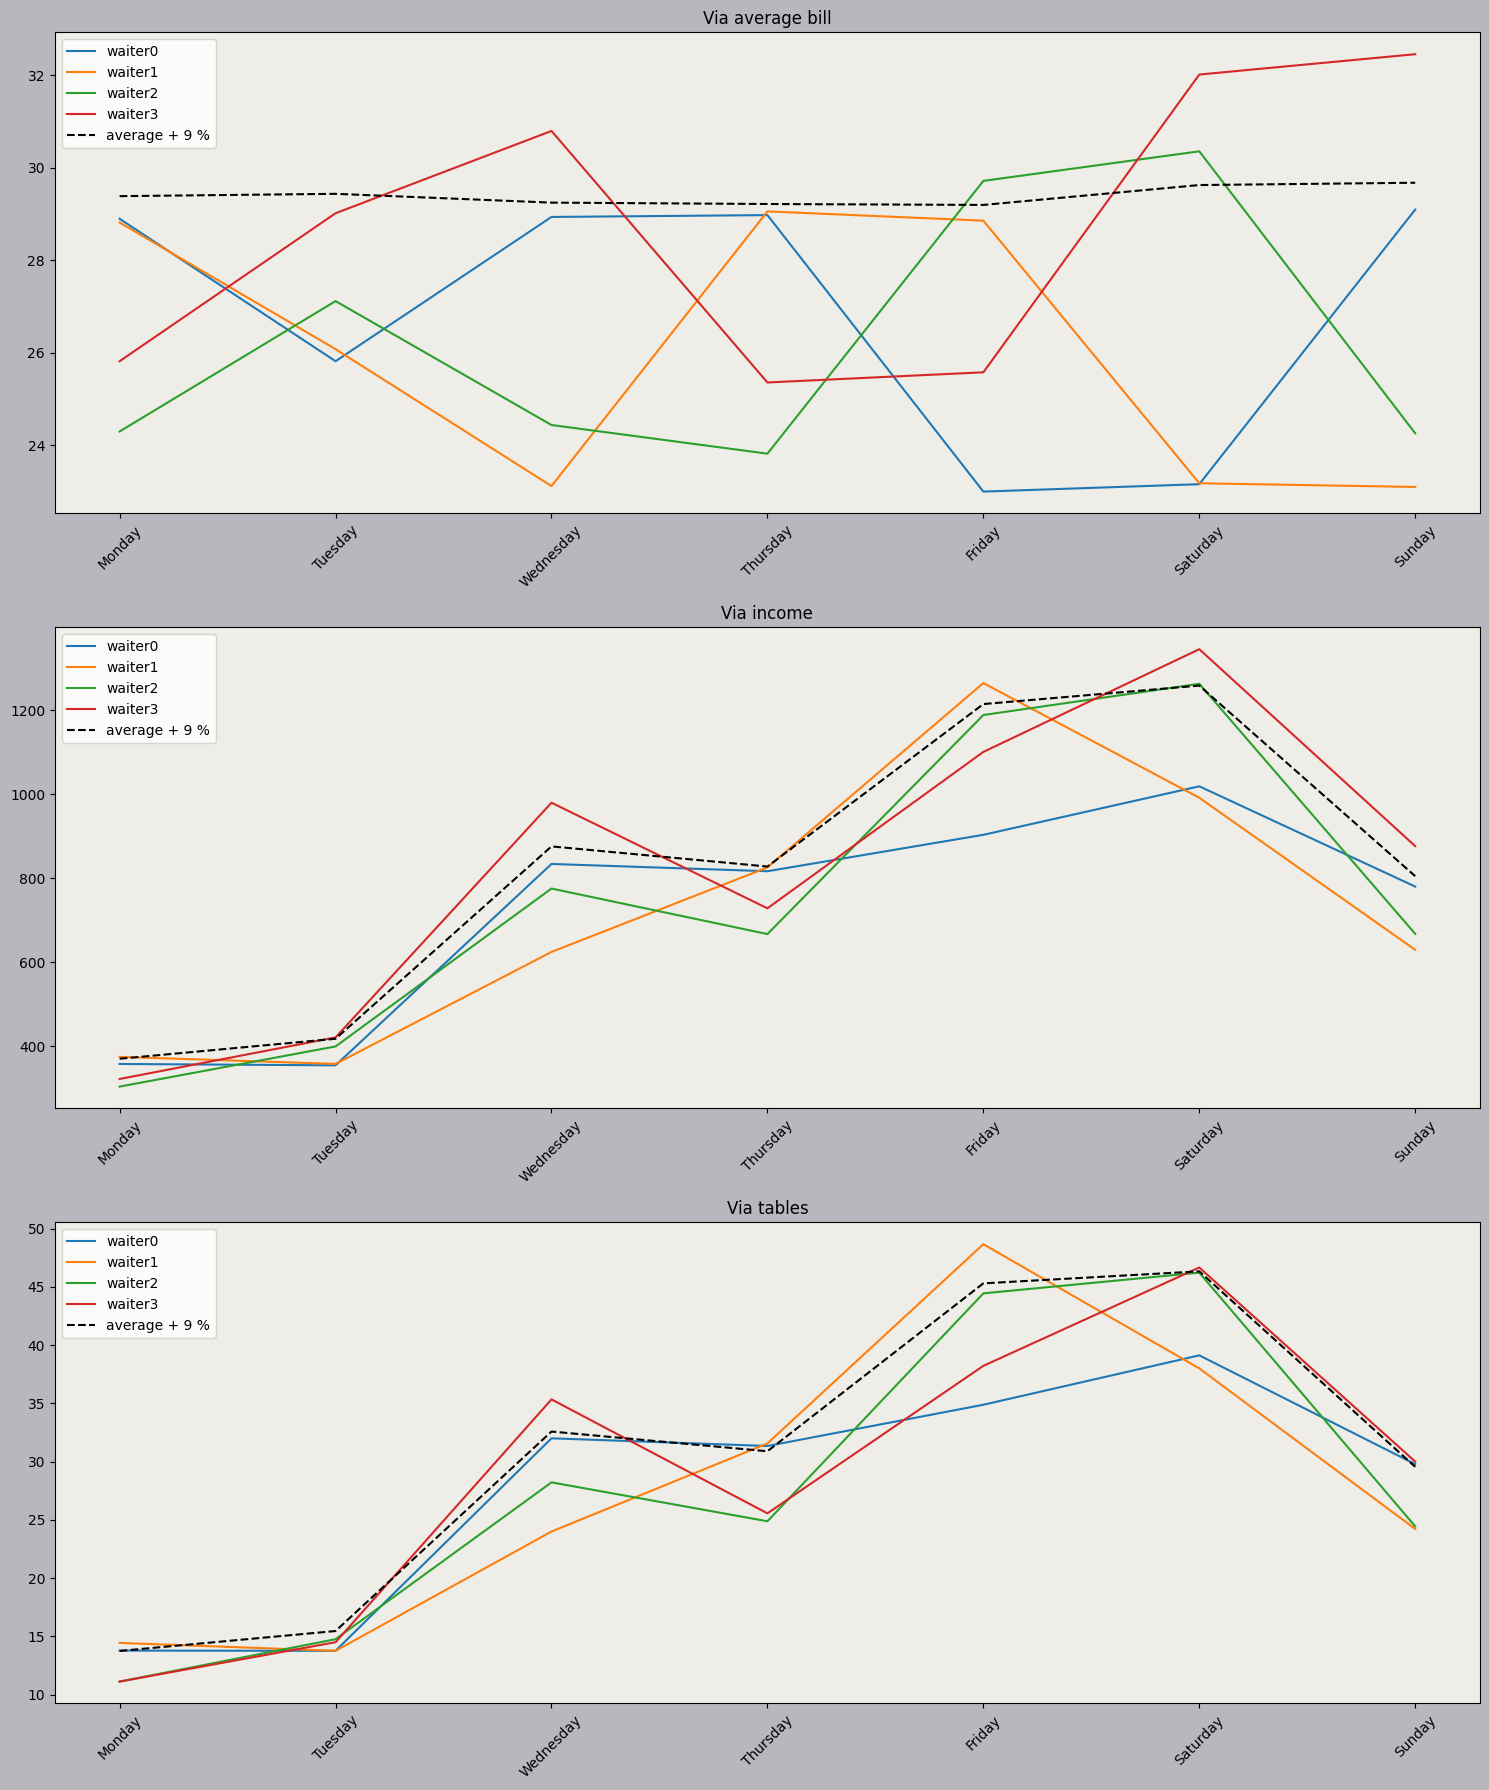

In [467]:
fig, ax = plt.subplots(3,1,figsize=(15, 18), facecolor = '#B9B7BD')
for i in range(4): # via waiters 0 - 3 and 4th is desired waiter
    sns.lineplot(x=range(7), y=list_avareges[i], ax=ax[0], label='waiter{}'.format(i))
    ax[0].set_title('Via average bill')
    ax[0].set_xticks(range(7))
    ax[0].set_xticklabels([days_of_week_dict[b % 7] for b in range(7)], rotation=45)
    ax[0].set_facecolor("#EEEDE7")
    
    sns.lineplot(x=range(7), y=list_income[i], ax=ax[1], label='waiter{}'.format(i))
    ax[1].set_title('Via income')
    ax[1].set_xticks(range(7))
    ax[1].set_xticklabels([days_of_week_dict[b % 7] for b in range(7)], rotation=45)
    ax[1].set_facecolor("#EEEDE7")
    
    sns.lineplot(x=range(7), y=list_tables[i], ax=ax[2], label='waiter{}'.format(i))
    ax[2].set_title('Via tables')
    ax[2].set_xticks(range(7))
    ax[2].set_xticklabels([days_of_week_dict[b % 7] for b in range(7)], rotation=45)
    ax[2].set_facecolor("#EEEDE7")  
    
sns.lineplot(list_avareges[4], ax=ax[0], color='black', linestyle='--', label = 'average + 9 %')
ax[0].legend(loc='upper left')

sns.lineplot(list_income[4], ax=ax[1], color='black', linestyle='--', label = 'average + 9 %')
ax[1].legend(loc='upper left')

sns.lineplot(list_tables[4], ax=ax[2], color='black', linestyle='--', label = 'average + 9 %')
ax[2].legend(loc='upper left')

plt.tight_layout()
plt.show()
    